In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.linear_model import Lasso, ElasticNet, Ridge

In [3]:
from sklearn.decomposition import PCA

In [4]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.metrics import AUC

In [6]:
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

In [7]:
from pybaseball import statcast

## preprocessing

In [329]:
#  Load data
pitches = pd.read_csv('../data/2023.csv')

In [330]:
#  Check again for nulls
pitches.isnull().sum().sum()

0

In [308]:
#  Limit data to combinations where a pitcher has thrown a particular pitch at least 30 times
pitches = pitches[pitches.groupby(['player_name','pitch_type']).transform('size') > 50]

In [331]:
pitches['fatigue'] = pitches['pitch_no'] ** 2

In [333]:
#  Define feature columns
features = ['vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z','ax','ay','az','release_spin_rate','release_extension','effective_speed',
        'release_pos_x','release_pos_y','release_pos_z','sz_top','sz_bot','pitch_type','player_name','pitch_no','inning','fatigue']

In [334]:
#  Define X and y for a model to predict probability of ball

y = pitches['hit']
X = pitches[features]

In [335]:
#  Dummify pitch type, but keep original for further preprocessing
X['pitch_type_orig'] = X['pitch_type']
X = pd.get_dummies(X, columns = ['pitch_type'])

C:\Users\rob\AppData\Local\Temp\ipykernel_13320\2939201450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pitch_type_orig'] = X['pitch_type']


In [336]:
#  Split into train and test, target variable = ball
X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, random_state=42)

In [337]:
#  Create '_diff' features which represent the amount of variance 
#  in each feature from the pitcher's mean (temporary '_avg' features) in the training data 
for col in features[:-5]:
    X_train[f'{col}_avg'] = X_train.groupby(['player_name', 'pitch_type_orig'])[col].transform('mean')
    avgs = X_train.groupby(['player_name', 'pitch_type_orig'])[col].mean().reset_index()
    merge = X_test.merge(avgs, on = ['player_name','pitch_type_orig'], how = 'left')
    X_test[f'{col}_avg'] = merge[col + '_y']
    X_train[f'{col}_diff'] = X_train[col] - X_train[f'{col}_avg']
    X_test[f'{col}_diff'] = X_test[col] - X_test[f'{col}_avg']    
    X_train.drop(columns = [col + '_avg'], inplace = True)   
    X_test.drop(columns = [col + '_avg'], inplace = True)

In [338]:
X_train.drop(columns = ['player_name','pitch_type_orig'], inplace = True)

In [339]:
X_test.drop(columns = ['player_name','pitch_type_orig'], inplace = True)

In [340]:
X_test.isnull().sum()

vx0                           0
vy0                           0
vz0                           0
release_speed                 0
pfx_x                         0
pfx_z                         0
plate_x                       0
plate_z                       0
ax                            0
ay                            0
az                            0
release_spin_rate             0
release_extension             0
effective_speed               0
release_pos_x                 0
release_pos_y                 0
release_pos_z                 0
sz_top                        0
sz_bot                        0
pitch_no                      0
inning                        0
fatigue                       0
pitch_type_CH                 0
pitch_type_CS                 0
pitch_type_CU                 0
pitch_type_EP                 0
pitch_type_FA                 0
pitch_type_FC                 0
pitch_type_FF                 0
pitch_type_FO                 0
pitch_type_FS                 0
pitch_ty

In [341]:
len(X_test.columns)

57

In [342]:
combined = pd.concat([X_test, y_test], axis = 1)

In [343]:
combined.dropna(inplace = True)

In [344]:
X_test = combined.iloc[:,:len(X_test.columns)]

In [345]:
y_test = combined.iloc[:,len(X_test.columns):]

## modeling

In [406]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [407]:
y_train = pd.read_csv('../data/y_train.csv', squeeze = True)
y_test = pd.read_csv('../data/y_test.csv', squeeze = True)

C:\Users\rob\AppData\Local\Temp\ipykernel_10756\2397831356.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y_train = pd.read_csv('../data/y_train.csv', squeeze = True)
C:\Users\rob\AppData\Local\Temp\ipykernel_10756\2397831356.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  y_test = pd.read_csv('../data/y_test.csv', squeeze = True)


In [408]:
pipe = Pipeline(steps = [
            ('ss',StandardScaler())
 #           ('poly',PolynomialFeatures())
        ])

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

X_train = pd.DataFrame(X_train, columns = pipe.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = pipe.get_feature_names_out())

In [409]:
#pca = PCA()

In [410]:
#X_train_pca = pca.fit_transform(X_train)[:,:10]
#X_test_pca = pca.transform(X_test)[:,:10]

In [411]:
from imblearn.over_sampling import RandomOverSampler

In [412]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((25292, 70), (8431, 70), (25292,), (8431,))

In [413]:
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

In [414]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35900, 70), (8431, 70), (35900,), (8431,))

In [399]:
pca = PCA()

In [400]:
pca.fit_transform(X_train)

array([[ 1.98371278e+00,  1.62009091e+00,  1.74850836e+00, ...,
         3.57726852e-16, -1.29941952e-17,  3.64634342e-16],
       [ 4.81639455e+00, -4.34842737e-01, -3.93567396e+00, ...,
         1.54582195e-15, -9.05620282e-15, -2.68448085e-15],
       [-3.48073320e+00,  2.45131512e-02, -1.97075982e-01, ...,
         6.86463584e-15, -5.49677746e-15,  3.92752608e-16],
       ...,
       [ 6.61903135e+00, -7.23314360e-01,  1.98724810e+00, ...,
         1.95082322e-16,  2.36229812e-16,  1.48808133e-16],
       [ 5.40749053e+00,  2.87458719e+00,  4.39174031e-01, ...,
         5.68828493e-16,  8.87819299e-17,  2.86814185e-16],
       [ 2.87790758e+00, -5.00875236e+00,  1.00447829e+00, ...,
         8.48452362e-17, -7.87795977e-18,  1.35259638e-16]])

In [401]:
pca.transform(X_test)

array([[ 3.85805567e+00, -1.78083801e+00,  1.51595698e+01, ...,
         2.58126853e-15, -6.43929354e-15,  3.16413562e-15],
       [ 3.58665995e+00,  2.40182141e-01,  2.92266285e+00, ...,
         7.21644966e-16, -6.93889390e-18,  8.84708973e-16],
       [-8.25395314e-01,  1.38012142e+00,  2.48414173e+00, ...,
         2.01227923e-15, -2.80331314e-15,  2.24820162e-15],
       ...,
       [-9.48441841e-01, -1.94704205e+00, -4.46640032e+00, ...,
        -1.60982339e-15, -1.83186799e-15,  1.08246745e-15],
       [-1.54961873e+00, -1.10987730e+00, -4.90042205e+00, ...,
        -1.40859546e-15,  3.88578059e-15, -2.87270208e-15],
       [ 3.01585882e+00, -1.38718613e+00, -1.75950574e+00, ...,
         6.07153217e-16, -5.27355937e-16,  6.10622664e-16]])

In [402]:
np.cumsum(pca.explained_variance_ratio_)[:200]

array([0.21269516, 0.29535234, 0.3683119 , 0.42849155, 0.48016725,
       0.52574964, 0.566285  , 0.60020891, 0.63290083, 0.66325595,
       0.69239176, 0.71989673, 0.74618384, 0.77117844, 0.7928109 ,
       0.81105523, 0.82789399, 0.84338384, 0.85847421, 0.87330132,
       0.88797464, 0.90233384, 0.91656785, 0.93042867, 0.94407082,
       0.95620286, 0.96633834, 0.9735036 , 0.97922542, 0.98343635,
       0.98727588, 0.99008308, 0.99255373, 0.9947992 , 0.99649998,
       0.99782045, 0.9984482 , 0.99891127, 0.99920883, 0.99948383,
       0.99965382, 0.99980206, 0.99985986, 0.99990342, 0.99993132,
       0.99995442, 0.99997492, 0.99998943, 0.99999564, 0.99999795,
       0.9999994 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [403]:
X_train = pca.fit_transform(X_train)[:,:30]

In [404]:
X_test = pca.transform(X_test)[:,:30]

In [171]:
from sklearn.metrics import f1_score

In [ ]:
mbda x: 1 if x['swing'] == 1 
                                   else 2 if x['called'] == 1
                                   else 3 if x['foul'] == 1
                                   else 4 if x['ball'] == 1
                                   else 5 if x['out'] == 1
                                   else 6 if x['hit'] == 1

In [181]:
f1_score(y_train, logr.predict(X_train), average = 'weighted')

0.3242831471698461

In [182]:
f1_score(y_test, logr.predict(X_test), average = 'weighted')

0.32043836948149435

In [416]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['AUC'])
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 16)

Epoch 1/10
2244/2244 [==============================] - 17s 5ms/step - loss: 0.6507 - auc: 0.6345 - val_loss: 0.7166 - val_auc: 0.5656
Epoch 2/10
2244/2244 [==============================] - 9s 4ms/step - loss: 0.6212 - auc: 0.6812 - val_loss: 0.7266 - val_auc: 0.5823
Epoch 3/10
2244/2244 [==============================] - 9s 4ms/step - loss: 0.6103 - auc: 0.7001 - val_loss: 0.7467 - val_auc: 0.5981
Epoch 4/10
2244/2244 [==============================] - 9s 4ms/step - loss: 0.6032 - auc: 0.7141 - val_loss: 0.6931 - val_auc: 0.5945
Epoch 5/10
2244/2244 [==============================] - 10s 4ms/step - loss: 0.5973 - auc: 0.7227 - val_loss: 0.7495 - val_auc: 0.6021
Epoch 6/10
2244/2244 [==============================] - 7s 3ms/step - loss: 0.5924 - auc: 0.7304 - val_loss: 0.7834 - val_auc: 0.6037
Epoch 7/10
2244/2244 [==============================] - 7s 3ms/step - loss: 0.5873 - auc: 0.7370 - val_loss: 0.7390 - val_auc: 0.5807
Epoch 8/10
2244/2244 [==============================] - 7s 3

In [417]:
y_pred = model.predict(X_test)

264/264 [==============================] - 5s 1ms/step


In [418]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

In [261]:
statcast()

start_dt 2023-05-13
end_dt 2023-05-14
This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.46s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1399,SL,2023-05-13,89.0,-2.15,4.54,"Díaz, Alexis",493329,664747,strikeout,swinging_strike,...,6,6,5,5,6,Standard,Standard,125,-0.271,-0.49
1436,FF,2023-05-13,95.1,-2.3,4.53,"Díaz, Alexis",493329,664747,NaN,foul,...,6,6,5,5,6,Standard,Standard,225,0.0,0.0
1439,FF,2023-05-13,95.0,-2.14,4.5,"Díaz, Alexis",493329,664747,NaN,foul,...,6,6,5,5,6,Standard,Standard,227,0.0,0.0
1500,FF,2023-05-13,94.4,-2.21,4.5,"Díaz, Alexis",493329,664747,NaN,swinging_strike,...,6,6,5,5,6,Standard,Standard,225,0.0,-0.171
1516,FF,2023-05-13,93.9,-2.23,4.52,"Díaz, Alexis",516416,664747,walk,ball,...,6,6,5,5,6,Standard,Standard,232,0.102,0.231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,FF,2023-05-13,95.0,-1.43,5.94,"Houser, Adrian",686469,605288,NaN,called_strike,...,0,0,0,0,0,Standard,Standard,219,0.0,-0.122
3608,FF,2023-05-13,94.7,-1.28,6.16,"Houser, Adrian",686469,605288,NaN,ball,...,0,0,0,0,0,Standard,Standard,220,0.0,0.066
3714,CU,2023-05-13,81.4,-1.6,5.95,"Houser, Adrian",677951,605288,double,hit_into_play,...,0,0,0,0,0,Standard,Standard,28,-0.06,0.703
3802,SI,2023-05-13,93.2,-1.55,5.99,"Houser, Adrian",677951,605288,NaN,called_strike,...,0,0,0,0,0,Standard,Standard,226,0.0,-0.05


In [258]:
res.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [243]:
from pybaseball import playerid_lookup

In [419]:
playerid_lookup('brigham','jeff')['key_mlbam']

0    656257
Name: key_mlbam, dtype: int32

In [246]:
from pybaseball import statcast_pitcher

In [ ]:
statcast_pitcher(start_dt = 

In [434]:
def predict(last, first, pitch, pitch_no):
    ball = X[(X['player_name'] == last + ', ' + first) & 
       (X['pitch_type_orig'] == pitch) & 
       (X['pitch_no'] > pitch_no - 5) & 
       (X['pitch_no'] < pitch_no + 5)]
    cols = ['vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z','ax','ay','az','release_spin_rate','release_extension','effective_speed',
        'release_pos_x','release_pos_y','release_pos_z']
    for col in cols:
        ball[f'{col}_diff'] = ball[col] - ball[col].mean()
    ball.drop(columns = ['pitch_type_orig','player_name'], inplace = True)
    return model_ball.predict(pipe.transform(ball)).mean()

In [452]:
predict_ball('Kershaw','Clayton','FF',60)

C:\Users\rob\AppData\Local\Temp\ipykernel_9824\1421490229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball[f'{col}_diff'] = ball[col] - ball[col].mean()
C:\Users\rob\AppData\Local\Temp\ipykernel_9824\1421490229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball[f'{col}_diff'] = ball[col] - ball[col].mean()
C:\Users\rob\AppData\Local\Temp\ipykernel_9824\1421490229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

1/1 [==============================] - 0s 172ms/step


0.4615338

In [428]:
cols = ['vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z','ax','ay','az','release_spin_rate','release_extension','effective_speed',
        'release_pos_x','release_pos_y','release_pos_z']

In [430]:
for col in cols:
    ck[f'{col}_diff'] = ck[col] - ck[col].mean()

C:\Users\rob\AppData\Local\Temp\ipykernel_9824\1687911216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ck[f'{col}_diff'] = ck[col] - ck[col].mean()


C:\Users\rob\AppData\Local\Temp\ipykernel_9824\3254636132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ck.drop(columns = ['pitch_type_orig','player_name'], inplace = True)


In [433]:
model.predict(pipe.transform(ck)).mean()

1/1 [==============================] - 0s 54ms/step


0.49795806

In [ ]:
def pitcher(last,first):
    

In [326]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [327]:
roc_auc_score(y_test, y_pred)

0.6106353603316734

In [328]:
confusion_matrix(y_pred, y_test)

array([[3018,  949],
       [1924, 1488]], dtype=int64)

In [5]:
def load_pitcher(last,first):
    pitcher = statcast_pitcher('2015-01-01','2023-05-09',
                               playerid_lookup(str(last),str(first))['key_mlbam'][0])
    pitcher['game_date'] = pd.to_datetime(pitcher['game_date'])
    pitcher['pitch_no'] = pitcher.groupby('game_date').cumcount() + 1
    pitcher['swing'] = pitcher['description'].apply(lambda x: 1 if x == 'swinging_strike' else 0)
    pitcher['ball'] = pitcher['type'].apply(lambda x: 1 if x == 'B' else 0)
    pitcher = pitcher[['pitch_type','release_speed','pfx_x','pfx_z',
            'plate_x','plate_z','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension','effective_speed','inning',
        'release_pos_x','release_pos_y','release_pos_z','pitch_no','swing','ball']]
    pitcher.dropna(inplace = True)
    pitches = []
    for i in pitcher['pitch_type'].unique():
        if pitcher['pitch_type'].value_counts(normalize = True).get(key = i) > 0.05:
            pitches.append(i)
    return pitcher, pitches

In [6]:
def model_ball(last,first):
    models = {}
    pitcher, pitches = load_pitcher(last,first)
    for pitch in pitches:
        X = pitcher[pitcher['pitch_type'] == pitch]
        y = X['ball']

        # final position of ball and size of strike zone gives away the result
        X = X.drop(columns = ['swing','ball','pitch_type','plate_x','plate_z','sz_top','sz_bot'])
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)
        pipe = Pipeline(steps = [
            ('ss',StandardScaler()),
            ('poly',PolynomialFeatures())
        ])

        X_train = pipe.fit_transform(X_train)
        X_test = pipe.transform(X_test)

        X_train = pd.DataFrame(X_train, columns = pipe.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns = pipe.get_feature_names_out())

        X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

        model = Sequential()
        model.add(Dense(128,activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32,activation = 'relu'))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(1,activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics = 'AUC')
        model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)
        models[pitch] = [pipe, model]
    return models

In [7]:
def model_ball(last,first):
    models = {}
    pitcher, pitches = load_pitcher(last,first)
    for pitch in pitches:
        X = pitcher[pitcher['pitch_type'] == pitch]
        y = X['ball']

        # final position of ball and size of strike zone gives away the result
        X = X.drop(columns = ['swing','ball','pitch_type','plate_x','plate_z','sz_top','sz_bot'])
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)
        pipe = Pipeline(steps = [
            ('ss',StandardScaler()),
            ('poly',PolynomialFeatures())
        ])

        X_train = pipe.fit_transform(X_train)
        X_test = pipe.transform(X_test)

        X_train = pd.DataFrame(X_train, columns = pipe.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns = pipe.get_feature_names_out())

        X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

        model = Sequential()
        model.add(Dense(128,activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32,activation = 'relu'))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(1,activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics = 'AUC')
        model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)
        models[pitch] = [pipe, model]
    return models

In [15]:
model_ball('Darvish','Yu')

Gathering Player Data


C:\Users\rob\anaconda3\lib\site-packages\pybaseball\utils.py:295: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))


Epoch 1/10
45/45 [==============================] - 2s 10ms/step - loss: 0.6742 - auc: 0.6311 - val_loss: 0.6130 - val_auc: 0.7555
Epoch 2/10
45/45 [==============================] - 0s 4ms/step - loss: 0.5620 - auc: 0.7948 - val_loss: 0.5196 - val_auc: 0.7885
Epoch 3/10
45/45 [==============================] - 0s 4ms/step - loss: 0.4865 - auc: 0.8463 - val_loss: 0.5283 - val_auc: 0.8074
Epoch 4/10
45/45 [==============================] - 0s 4ms/step - loss: 0.4347 - auc: 0.8861 - val_loss: 0.4688 - val_auc: 0.8516
Epoch 5/10
45/45 [==============================] - 0s 4ms/step - loss: 0.3811 - auc: 0.9138 - val_loss: 0.4751 - val_auc: 0.8474
Epoch 6/10
45/45 [==============================] - 0s 4ms/step - loss: 0.3412 - auc: 0.9325 - val_loss: 0.4836 - val_auc: 0.8483
Epoch 7/10
45/45 [==============================] - 0s 4ms/step - loss: 0.3073 - auc: 0.9445 - val_loss: 0.4637 - val_auc: 0.8572
Epoch 8/10
45/45 [==============================] - 0s 4ms/step - loss: 0.2823 - auc: 0.9

{'ST': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
 'FC': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
 'FF': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
 'SL': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
 'SI': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
 'FS': [Pipeline(steps=[('ss', StandardScaler()), ('poly', PolynomialFeatures())]),
  <keras.engine.sequential.Sequential at 0x26bdbf4d3f0>]}

In [7]:
def enter_pitch(last,first,pitch,pitch_no):
        pitcher, pitches = load_pitcher(last,first)
        new = pd.DataFrame(pitcher.loc[(pitcher['pitch_type'] == pitch) & \
                                       (pitcher['pitch_no'] > pitch_no - 5) & \
                                       (pitcher['pitch_no'] < pitch_no + 5), :].agg('mean').copy())
        new = new.T.drop(columns = ['swing','ball','plate_x','plate_z','sz_top','sz_bot'])
        pipe, model = model_ball(last,first)[pitch]
        new = pipe.transform(new)
        new = pd.DataFrame(new, columns = pipe.get_feature_names_out())
        return model.predict(new)

In [8]:
enter_pitch('darvish','yu','FF',40)

Gathering player lookup table. This may take a moment.
Gathering Player Data


C:\Users\rob\anaconda3\lib\site-packages\pybaseball\utils.py:295: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))
C:\Users\rob\AppData\Local\Temp\ipykernel_19100\1980678270.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (pitcher['pitch_no'] < pitch_no + 5), :].agg('mean').copy())


Gathering Player Data


C:\Users\rob\anaconda3\lib\site-packages\pybaseball\utils.py:295: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(data.text))


Epoch 1/10
45/45 [==============================] - 2s 15ms/step - loss: 0.6897 - auc: 0.6170 - val_loss: 0.6549 - val_auc: 0.7150
Epoch 2/10
45/45 [==============================] - 0s 7ms/step - loss: 0.5629 - auc: 0.7954 - val_loss: 0.5634 - val_auc: 0.7746
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.4874 - auc: 0.8537 - val_loss: 0.4920 - val_auc: 0.8059
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.4368 - auc: 0.8852 - val_loss: 0.4965 - val_auc: 0.8162
Epoch 5/10
45/45 [==============================] - 0s 6ms/step - loss: 0.3858 - auc: 0.9118 - val_loss: 0.4961 - val_auc: 0.8286
Epoch 6/10
45/45 [==============================] - 0s 5ms/step - loss: 0.3624 - auc: 0.9221 - val_loss: 0.4839 - val_auc: 0.8389
Epoch 7/10
45/45 [==============================] - 0s 4ms/step - loss: 0.3215 - auc: 0.9385 - val_loss: 0.4979 - val_auc: 0.8483
Epoch 8/10
45/45 [==============================] - 0s 4ms/step - loss: 0.2804 - auc: 0.9

array([[0.04002418]], dtype=float32)

In [49]:
class pitching:
    def __init__(self, last, first, pitch, pitch_no):
        self.last = last
        self.first = first
        self.pitch = pitch
        self.pitch_no = pitch_no
    
    def load_pitcher(self):
        pitcher = statcast_pitcher('2015-01-01','2023-05-09',
                                   playerid_lookup(str(self.last),str(self.first))['key_mlbam'][0])
        pitcher['game_date'] = pd.to_datetime(pitcher['game_date'])
        pitcher['pitch_no'] = pitcher.groupby('game_date').cumcount() + 1
        pitcher['swing'] = pitcher['description'].apply(lambda x: 1 if x == 'swinging_strike' else 0)
        pitcher['ball'] = pitcher['type'].apply(lambda x: 1 if x == 'B' else 0)
        pitcher = pitcher[['pitch_type','release_speed','pfx_x','pfx_z',
                'plate_x','plate_z','vx0','vy0','vz0',
                'ax','ay','az','sz_top','sz_bot',
                'release_spin_rate','release_extension','effective_speed','inning',
            'release_pos_x','release_pos_y','release_pos_z','pitch_no','swing','ball']]
        pitcher.dropna(inplace = True)
        return pitcher
    
    def model_ball(self):
        
        pitcher = self.load_pitcher(self)
        X = pitcher[pitcher['pitch_type'] == pitch]
        y = X['ball']

        # final position of ball and size of strike zone gives away the result
        X = X.drop(columns = ['swing','ball','pitch_type','plate_x','plate_z','sz_top','sz_bot'])
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)
        pipe = Pipeline(steps = [
            ('ss',StandardScaler()),
            ('poly',PolynomialFeatures())
        ])

        X_train = pipe.fit_transform(X_train)
        X_test = pipe.transform(X_test)

        X_train = pd.DataFrame(X_train, columns = pipe.get_feature_names_out())
        X_test = pd.DataFrame(X_test, columns = pipe.get_feature_names_out())

        X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

        model = Sequential()
        model.add(Dense(128,activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32,activation = 'relu'))
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(1,activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics = 'AUC')
        model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

        return pipe, model
    
    def enter_pitch(self):
        pitcher = self.load_pitcher(self)
        new = pd.DataFrame(pitcher.loc[(pitcher['pitch_type'] == pitch) & (pitcher['pitch_no'] > pitch_no - 5) & (pitcher['pitch_no'] < pitch_no + 5), :].agg('mean').copy())
        new = new.T.drop(columns = ['swing','ball','plate_x','plate_z','sz_top','sz_bot'])
        pipe, model = self.model_ball(self)
        new = pipe.transform(new)
        new = pd.DataFrame(new, columns = pipe.get_feature_names_out())
        return model.predict(new)

### plots

In [13]:
ff = pitcher[pitcher['pitch_type'] == 'FF']

<Axes: xlabel='pitch_no'>

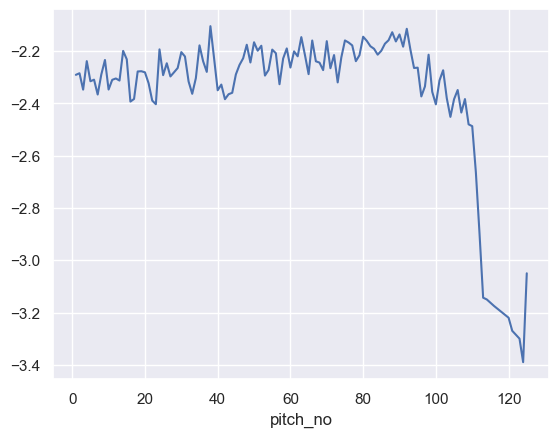

In [17]:
ff.groupby('pitch_no')['release_pos_x'].mean().plot()

<Axes: xlabel='pitch_no'>

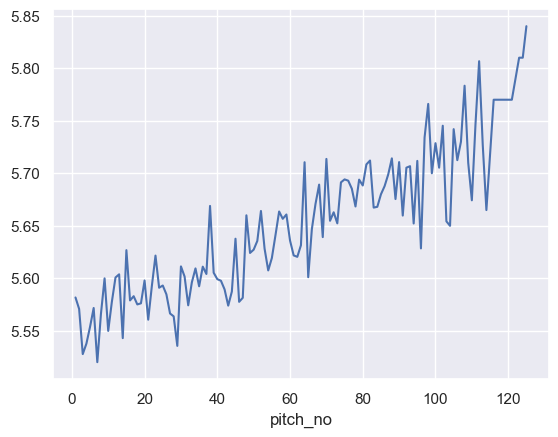

In [18]:
ff.groupby('pitch_no')['release_pos_z'].mean().plot()

<Axes: xlabel='pitch_no'>

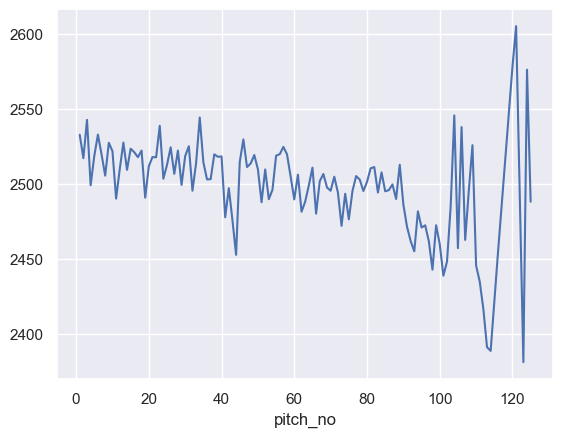

In [16]:
ff.groupby('pitch_no')['release_spin_rate'].mean().plot()

<Axes: xlabel='pitch_no'>

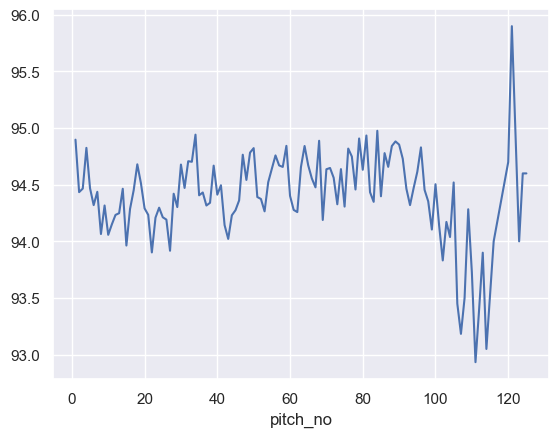

In [15]:
ff.groupby('pitch_no')['release_speed'].mean().plot()

<Axes: xlabel='pitch_no'>

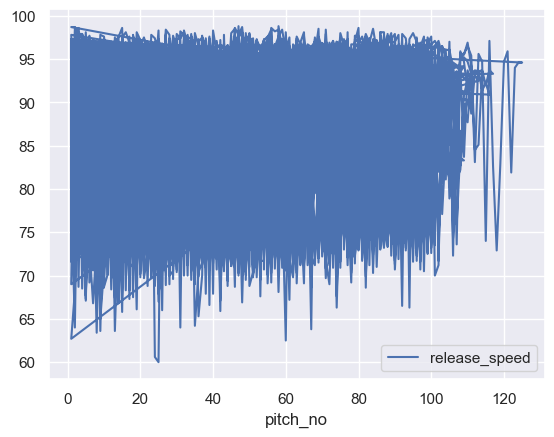

In [12]:
pitcher.plot(kind = 'line', y = 'release_speed', x = 'pitch_no')

## balls

['ST', 'FC', 'FF', 'SL', 'SI', 'FS']

In [86]:
predict_ball('FF',95)

Epoch 1/10
154/154 [==============================] - 2s 4ms/step - loss: 0.6109 - auc: 0.7319 - val_loss: 0.5161 - val_auc: 0.8119
Epoch 2/10
154/154 [==============================] - 0s 3ms/step - loss: 0.4638 - auc: 0.8606 - val_loss: 0.4221 - val_auc: 0.8873
Epoch 3/10
154/154 [==============================] - 0s 3ms/step - loss: 0.3924 - auc: 0.9018 - val_loss: 0.3875 - val_auc: 0.8956
Epoch 4/10
154/154 [==============================] - 0s 3ms/step - loss: 0.3404 - auc: 0.9286 - val_loss: 0.3806 - val_auc: 0.9076
Epoch 5/10
154/154 [==============================] - 0s 3ms/step - loss: 0.2983 - auc: 0.9448 - val_loss: 0.3796 - val_auc: 0.9081
Epoch 6/10
154/154 [==============================] - 0s 3ms/step - loss: 0.2787 - auc: 0.9520 - val_loss: 0.3779 - val_auc: 0.9106
Epoch 7/10
154/154 [==============================] - 0s 3ms/step - loss: 0.2674 - auc: 0.9559 - val_loss: 0.3615 - val_auc: 0.9188
Epoch 8/10
154/154 [==============================] - 0s 3ms/step - loss: 0.

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_4436\117736292.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  new_pitch = pd.DataFrame(pitcher.loc[(pitcher['pitch_type'] == pitch) & (pitcher['pitch_no'] > pitch_no - 5) & (pitcher['pitch_no'] < pitch_no + 5), :].agg('mean').copy())


array([[0.01888628]], dtype=float32)

In [41]:
y_pred = model.predict(X_test) 

126/126 [==============================] - 0s 1ms/step


In [42]:
roc_auc_score(y_test, y_pred)

0.9111937025829936

In [43]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [44]:
confusion_matrix(y_pred, y_test)

array([[2036,  170],
       [ 604, 1212]], dtype=int64)

## swinging strikes

In [87]:
X = pitcher.drop(columns = ['swing','ball'])
y = pitcher['swing']

In [88]:
X = pd.get_dummies(X, columns = ['pitch_type'])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [90]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [91]:
poly = PolynomialFeatures()
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [92]:
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

In [93]:
base = [np.mean(y_train)] * len(y_test)
roc_auc_score(y_test, base)

0.5

In [119]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = 'AUC')

In [120]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 8)

Epoch 1/10
345/345 [==============================] - 3s 5ms/step - loss: 0.6718 - auc: 0.6236 - val_loss: 0.5573 - val_auc: 0.6681
Epoch 2/10
345/345 [==============================] - 1s 4ms/step - loss: 0.6303 - auc: 0.6899 - val_loss: 0.6962 - val_auc: 0.6834
Epoch 3/10
345/345 [==============================] - 1s 4ms/step - loss: 0.6109 - auc: 0.7156 - val_loss: 0.6184 - val_auc: 0.6895
Epoch 4/10
345/345 [==============================] - 1s 4ms/step - loss: 0.5987 - auc: 0.7376 - val_loss: 0.5368 - val_auc: 0.6964
Epoch 5/10
345/345 [==============================] - 1s 4ms/step - loss: 0.5822 - auc: 0.7524 - val_loss: 0.6167 - val_auc: 0.6935
Epoch 6/10
345/345 [==============================] - 1s 4ms/step - loss: 0.5679 - auc: 0.7665 - val_loss: 0.6426 - val_auc: 0.6932
Epoch 7/10
345/345 [==============================] - 1s 4ms/step - loss: 0.5615 - auc: 0.7757 - val_loss: 0.6101 - val_auc: 0.7047
Epoch 8/10
345/345 [==============================] - 1s 4ms/step - loss: 0.

In [121]:
y_pred = model.predict(X_test) 

126/126 [==============================] - 0s 1ms/step


In [122]:
roc_auc_score(y_test, y_pred)

0.7070194318789824

In [123]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [124]:
confusion_matrix(y_pred, y_test)

array([[2056,  131],
       [1504,  331]], dtype=int64)

## loogy

In [7]:
l_rel = pd.read_csv('../data/l_rel.csv')

In [8]:
from pybaseball.lahman import pitching

In [9]:
data = pitching()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50402 entries, 0 to 50401
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  50402 non-null  object 
 1   yearID    50402 non-null  int64  
 2   stint     50402 non-null  int64  
 3   teamID    50402 non-null  object 
 4   lgID      50270 non-null  object 
 5   W         50402 non-null  int64  
 6   L         50402 non-null  int64  
 7   G         50402 non-null  int64  
 8   GS        50402 non-null  int64  
 9   CG        50402 non-null  int64  
 10  SHO       50402 non-null  int64  
 11  SV        50402 non-null  int64  
 12  IPouts    50402 non-null  int64  
 13  H         50402 non-null  int64  
 14  ER        50402 non-null  int64  
 15  HR        50402 non-null  int64  
 16  BB        50402 non-null  int64  
 17  SO        50402 non-null  int64  
 18  BAOpp     45958 non-null  float64
 19  ERA       50305 non-null  float64
 20  IBB       35824 non-null  fl

In [11]:
data['IPG'] = data['IPouts']/data['G']

In [12]:
data['BFG'] = data['BFP']/data['G']

In [13]:
oogy = list(data[(data['BFG'] < 3) & (data['BFG'] > 0) & (data['yearID'] > 2014) & (data['BFP'] > 20)]['playerID'])

In [14]:
l_rel['loogy'] = l_rel['player_name'].apply(lambda x: \
                                            1 if x.split()[0][:5].lower()\
                                       + x.split()[1][:2].lower() + '01' in oogy else 0)

In [15]:
l_rel['loogy'].value_counts()

0    185365
1     43754
Name: loogy, dtype: int64

In [91]:
X = l_rel[['pitch_type','release_speed','pfx_x','pfx_z',
            'plate_x','plate_z','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension',
            'release_pos_x','release_pos_y','release_pos_z']]

In [92]:
X = pd.get_dummies(X, columns = ['pitch_type'])

In [93]:
y = l_rel['loogy']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, random_state=42)

In [95]:
from imblearn.under_sampling import RandomUnderSampler

In [96]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [97]:
X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())

In [98]:
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [99]:
poly = PolynomialFeatures()

In [100]:
X_train = poly.fit_transform(X_train)

In [101]:
X_test = poly.transform(X_test)

In [102]:
X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

In [103]:
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [104]:
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

In [105]:
base = [np.mean(y_train)] * len(y_test)

In [106]:
roc_auc_score(y_test,base)

0.5

In [107]:
logr = LogisticRegression(C = 100)

In [108]:
logr.fit(X_train,y_train)

C:\Users\rob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [109]:
roc_auc_score(y_test,logr.predict(X_test))

0.7601632330043885

In [110]:
X_train.columns

Index(['1', 'release_speed', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0',
       'vy0', 'vz0', 'ax',
       ...
       'pitch_type_SI^2', 'pitch_type_SI pitch_type_SL',
       'pitch_type_SI pitch_type_ST', 'pitch_type_SI pitch_type_SV',
       'pitch_type_SL^2', 'pitch_type_SL pitch_type_ST',
       'pitch_type_SL pitch_type_SV', 'pitch_type_ST^2',
       'pitch_type_ST pitch_type_SV', 'pitch_type_SV^2'],
      dtype='object', length=528)

In [59]:
coefs = pd.DataFrame({"Feature":X_train.columns.tolist(),"Coefficients":logr.coef_[0]})

In [65]:
coefs.sort_values(by = 'Coefficients', key = abs, ascending = False).head(50)

,Feature,Coefficients
14,release_spin_rate,-0.526110
258,ax release_extension,0.492481
77,pfx_x release_pos_x,-0.486087
434,release_pos_z pitch_type_SL,0.469489
390,release_extension pitch_type_ST,0.460258
433,release_pos_z pitch_type_SI,-0.423760
189,vx0 release_pos_z,-0.422626
406,release_pos_x pitch_type_ST,0.415438
64,pfx_x pfx_z,-0.411794
432,release_pos_z pitch_type_KC,0.387680


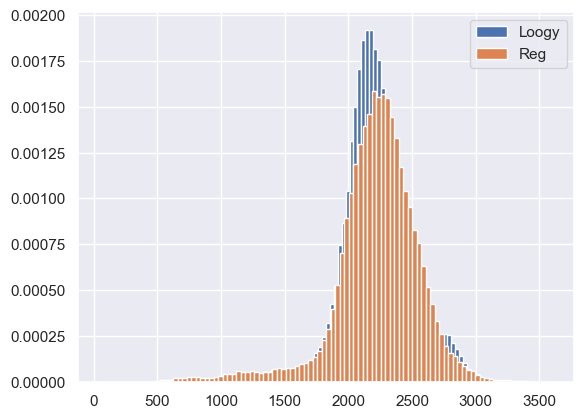

In [71]:
l_rel[l_rel['loogy'] == 1]['release_spin_rate'].hist(density = True, bins = 100, label = 'Loogy')
l_rel[l_rel['loogy'] == 0]['release_spin_rate'].hist(density = True, bins = 100, label = 'Reg')
plt.legend()

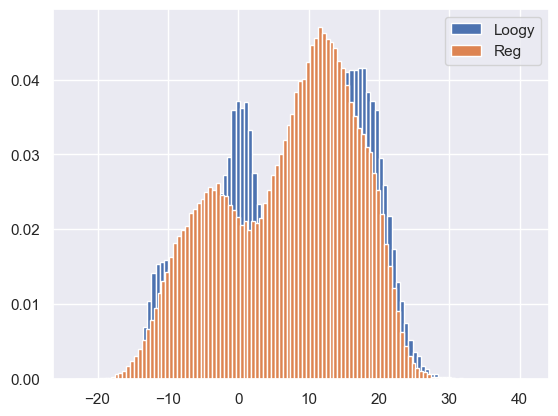

In [72]:
l_rel[l_rel['loogy'] == 1]['ax'].hist(density = True, bins = 100, label = 'Loogy')
l_rel[l_rel['loogy'] == 0]['ax'].hist(density = True, bins = 100, label = 'Reg')
plt.legend()

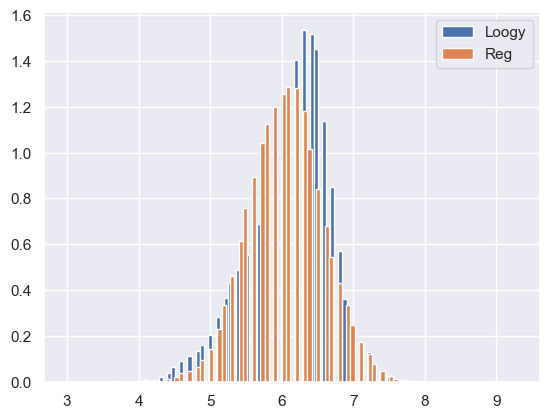

In [73]:
l_rel[l_rel['loogy'] == 1]['release_extension'].hist(density = True, bins = 100, label = 'Loogy')
l_rel[l_rel['loogy'] == 0]['release_extension'].hist(density = True, bins = 100, label = 'Reg')
plt.legend()

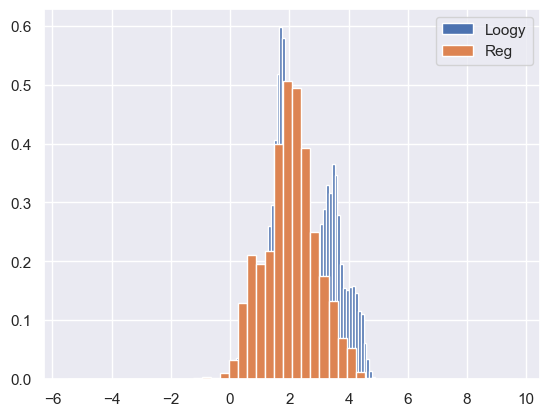

In [113]:
l_rel[l_rel['loogy'] == 1]['release_pos_x'].hist(density = True, bins = 50, label = 'Loogy')
l_rel[l_rel['loogy'] == 0]['release_pos_x'].hist(density = True, bins = 50, label = 'Reg')
plt.legend()

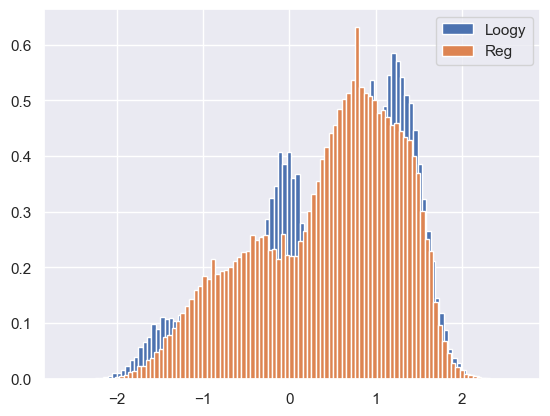

In [114]:
l_rel[l_rel['loogy'] == 1]['pfx_x'].hist(density = True, bins = 100, label = 'Loogy')
l_rel[l_rel['loogy'] == 0]['pfx_x'].hist(density = True, bins = 100, label = 'Reg')
plt.legend()

In [50]:
max(coefs)

'vz0^2'

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

In [ ]:
roc_auc_score(y_test, dt.predict(X_test))

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
roc_auc_score(y_test,knn.predict(X_test))

In [ ]:
svc = SVC()
svc.fit(X_train,y_train)
roc_auc_score(y_test,svc.predict(X_test))

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.metrics import AUC

In [58]:
model = Sequential()
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = 'AUC')

In [59]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 128)

Epoch 1/10
513/513 [==============================] - 5s 5ms/step - loss: 0.4626 - auc: 0.8636 - val_loss: 0.3450 - val_auc: 0.9321
Epoch 2/10
513/513 [==============================] - 2s 4ms/step - loss: 0.3234 - auc: 0.9407 - val_loss: 0.2736 - val_auc: 0.9537
Epoch 3/10
513/513 [==============================] - 2s 4ms/step - loss: 0.2749 - auc: 0.9581 - val_loss: 0.2630 - val_auc: 0.9617
Epoch 4/10
513/513 [==============================] - 2s 4ms/step - loss: 0.2352 - auc: 0.9663 - val_loss: 0.2194 - val_auc: 0.9664
Epoch 5/10
513/513 [==============================] - 2s 4ms/step - loss: 0.2140 - auc: 0.9720 - val_loss: 0.2268 - val_auc: 0.9709
Epoch 6/10
513/513 [==============================] - 3s 5ms/step - loss: 0.2004 - auc: 0.9754 - val_loss: 0.2344 - val_auc: 0.9734
Epoch 7/10
513/513 [==============================] - 3s 5ms/step - loss: 0.1918 - auc: 0.9774 - val_loss: 0.2176 - val_auc: 0.9718
Epoch 8/10
513/513 [==============================] - 3s 5ms/step - loss: 0.

In [60]:
y_pred = model.predict(X_test) >= 0.5

1790/1790 [==============================] - 2s 1ms/step


In [61]:
roc_auc_score(y_test, y_pred)

0.9218049255131338

In [62]:
confusion_matrix(y_pred,y_test)

array([[43186,   966],
       [ 3155,  9973]], dtype=int64)

## fatigue through game

### fewer swinging strikes

In [39]:
X = ck[['pitch_type','release_speed','pfx_x','pfx_z',
            'plate_x','plate_z','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension','effective_speed','inning',
        'release_pos_x','release_pos_y','release_pos_z','pitch_no','swing']]

In [40]:
X.isnull().sum()

pitch_type           181
release_speed        176
pfx_x                181
pfx_z                181
plate_x              181
plate_z              181
vx0                  181
vy0                  181
vz0                  181
ax                   181
ay                   181
az                   181
sz_top               181
sz_bot               181
release_spin_rate    929
release_extension    345
effective_speed      174
inning                 0
delta_run_exp          6
release_pos_x        181
release_pos_y        181
release_pos_z        181
pitch_no               0
swing                  0
dtype: int64

In [41]:
X.dropna(inplace = True)

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_17840\25841689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


In [42]:
X = pd.get_dummies(X, columns = ['pitch_type'])

In [43]:
y = X['swing']

In [44]:
X.drop(columns = 'swing', inplace = True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [46]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [49]:
poly = PolynomialFeatures()
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [52]:
base = [np.mean(y_train)] * len(y_test)
roc_auc_score(y_test, base)

0.5

In [85]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics = ['AUC'])

In [86]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
405/405 [==============================] - 2s 3ms/step - loss: 0.3546 - auc: 0.7252 - val_loss: 0.3070 - val_auc: 0.7948
Epoch 2/10
405/405 [==============================] - 1s 3ms/step - loss: 0.3103 - auc: 0.8040 - val_loss: 0.3043 - val_auc: 0.7990
Epoch 3/10
405/405 [==============================] - 1s 2ms/step - loss: 0.2936 - auc: 0.8325 - val_loss: 0.2948 - val_auc: 0.8200
Epoch 4/10
405/405 [==============================] - 1s 3ms/step - loss: 0.2822 - auc: 0.8492 - val_loss: 0.2895 - val_auc: 0.8323
Epoch 5/10
405/405 [==============================] - 1s 3ms/step - loss: 0.2692 - auc: 0.8644 - val_loss: 0.2838 - val_auc: 0.8408
Epoch 6/10
405/405 [==============================] - 1s 3ms/step - loss: 0.2617 - auc: 0.8740 - val_loss: 0.2812 - val_auc: 0.8437
Epoch 7/10
405/405 [==============================] - 1s 3ms/step - loss: 0.2514 - auc: 0.8865 - val_loss: 0.2820 - val_auc: 0.8446
Epoch 8/10
405/405 [==============================] - 1s 3ms/step - loss: 0.

In [87]:
y_pred = model.predict(X_test)

135/135 [==============================] - 0s 1ms/step


In [88]:
roc_auc_score(y_test, y_pred)

0.8447126978658592

### balls

In [248]:
ck['ball'] = ck['type'].apply(lambda x: 1 if x == 'B' else 0)

In [259]:
X = ck[['pitch_type','release_speed','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension','effective_speed','inning',
            'release_pos_x','release_pos_y','release_pos_z','pitch_no','ball']]
X.dropna(inplace = True)
X = pd.get_dummies(X, columns = ['pitch_type'])
y = X['ball']
X = X.drop(columns = 'ball')

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_17840\726466357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [ ]:
X_train['ball']

KeyError: 'ball'

In [261]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [262]:
poly = PolynomialFeatures()
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [263]:
base = [np.mean(y_train)] * len(y_test)
roc_auc_score(y_test, base)

0.5

In [264]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse',optimizer='adam')

In [265]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
423/423 [==============================] - 2s 2ms/step - loss: 1.9722 - val_loss: 4.2044
Epoch 2/10
423/423 [==============================] - 1s 2ms/step - loss: 2.4159 - val_loss: 0.2499
Epoch 3/10
423/423 [==============================] - 1s 2ms/step - loss: 0.3012 - val_loss: 0.2148
Epoch 4/10
423/423 [==============================] - 1s 2ms/step - loss: 3.3095 - val_loss: 0.2411
Epoch 5/10
423/423 [==============================] - 1s 2ms/step - loss: 0.5250 - val_loss: 0.2424
Epoch 6/10
423/423 [==============================] - 1s 2ms/step - loss: 12.7448 - val_loss: 0.2183
Epoch 7/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2575 - val_loss: 0.8186
Epoch 8/10
423/423 [==============================] - 1s 2ms/step - loss: 0.6870 - val_loss: 0.2685
Epoch 9/10
423/423 [==============================] - 1s 2ms/step - loss: 9.5449 - val_loss: 0.2287
Epoch 10/10
423/423 [==============================] - 1s 2ms/step - loss: 0.4952 - val_loss: 0.214

In [266]:
y_pred = model.predict(X_test)

141/141 [==============================] - 0s 979us/step


In [267]:
roc_auc_score(y_test, y_pred)

0.5440852051111157

### fewer called strikes

In [ ]:
#  events, description, hit_location, bb_type, hit_distance_sc, delta_run_exp

In [203]:
ck['events'].value_counts()

field_out                    1986
strikeout                    1407
single                        641
walk                          213
double                        168
home_run                      130
grounded_into_double_play      82
force_out                      74
field_error                    40
sac_bunt                       24
hit_by_pitch                   18
triple                         13
sac_fly                        11
fielders_choice                 8
fielders_choice_out             7
double_play                     6
catcher_interf                  4
strikeout_double_play           3
caught_stealing_2b              3
intent_walk                     2
caught_stealing_home            1
sac_bunt_double_play            1
Name: events, dtype: int64

In [90]:
ck.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

### delta run exp

In [168]:
X = ck[['pitch_type','release_speed','pfx_x','pfx_z',
            'plate_x','plate_z','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension','effective_speed','inning',
            'release_pos_x','release_pos_y','release_pos_z','pitch_no','delta_run_exp']]

In [169]:
X.dropna(inplace = True)

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_17840\25841689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


In [170]:
y = X['delta_run_exp']

In [171]:
X = X.drop(columns = 'delta_run_exp')

In [172]:
X = pd.get_dummies(X, columns = ['pitch_type'])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [174]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [175]:
poly = PolynomialFeatures()
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [176]:
base = [np.mean(y_train)] * len(y_test)
mean_squared_error(y_test, base, squared=False)

0.2118249216952286

In [177]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse',optimizer='adam')

In [178]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
188/188 [==============================] - 2s 3ms/step - loss: 0.0450 - val_loss: 0.0447
Epoch 2/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.0449
Epoch 3/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0451
Epoch 4/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0458
Epoch 5/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0461
Epoch 6/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0448
Epoch 7/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0398 - val_loss: 0.0450
Epoch 8/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0450
Epoch 9/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0461
Epoch 10/10
188/188 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0457

In [179]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [180]:
mean_squared_error(y_test, y_pred, squared=False)

0.21379986599690892

## mechanics

#### fastball velocity

In [191]:
ck = ck[ck['pitch_type'] == 'FF']

In [192]:
X = ck[['pfx_x','pfx_z',
            'plate_x','plate_z','vx0','vy0','vz0',
            'ax','ay','az','sz_top','sz_bot',
            'release_spin_rate','release_extension','effective_speed','inning',
            'release_pos_x','release_pos_y','release_pos_z','pitch_no','release_speed']]
X.dropna(inplace = True)
y = X['release_speed']
X.drop(columns = 'release_speed')

C:\Users\Finley & Stein\AppData\Local\Temp\ipykernel_17840\3392740547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_spin_rate,release_extension,effective_speed,inning,release_pos_x,release_pos_y,release_pos_z,pitch_no
1,-0.22,1.65,-0.97,2.82,-4.795000,-137.464000,-7.076000,-1.522000,34.627000,-10.191000,3.61,1.57,2377.0,6.5,94.0,5,0.92,50.00,6.14,2
4,-0.03,1.74,-1.78,1.84,-7.810000,-135.858000,-9.625000,1.261000,27.852000,-9.069000,3.42,1.51,2391.0,6.6,93.6,5,1.04,50.00,6.04,5
5,-0.66,1.58,-0.12,2.36,-1.940000,-137.062000,-7.767000,-7.657000,34.975000,-10.969000,3.42,1.47,2315.0,6.5,93.8,5,1.14,50.00,6.01,6
7,0.49,1.90,0.96,1.32,-2.652000,-137.073000,-11.628000,6.630000,29.854000,-6.227000,3.75,1.64,2338.0,6.6,94.5,5,1.48,50.00,6.04,8
8,0.18,1.72,-0.46,3.21,-4.678000,-137.196000,-6.301000,3.275000,30.735000,-9.518000,3.66,1.54,2253.0,6.7,94.7,5,1.04,50.00,6.19,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18184,-0.40,1.57,-0.33,2.52,-3.524664,-131.515107,-6.378435,-3.980430,26.766435,-12.799638,3.50,1.65,2342.0,6.4,90.7,2,1.43,54.11,6.11,88
18185,-0.37,1.51,0.82,4.29,-0.832675,-132.912806,-2.271370,-4.220362,27.587624,-14.005365,3.53,1.68,2365.0,6.5,91.8,2,1.46,54.02,6.23,89
18187,-0.10,1.71,0.84,3.56,-1.568255,-132.391093,-4.116400,-0.745037,33.478473,-11.592067,3.50,1.69,2322.0,6.5,90.6,2,1.55,54.02,6.13,91
18189,0.00,1.80,1.97,3.64,0.730560,-132.765704,-4.148554,-0.161907,32.548116,-10.343355,3.73,1.86,2502.0,6.6,91.1,3,1.68,53.94,6.11,93


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [194]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train, columns = ss.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = ss.get_feature_names_out())

In [195]:
poly = PolynomialFeatures()
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns = poly.get_feature_names_out())

In [196]:
base = [np.mean(y_train)] * len(y_test)
mean_squared_error(y_test, base, squared=False)

1.8182370499669918

In [197]:
model = Sequential()
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse',optimizer='adam')

In [198]:
model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
188/188 [==============================] - 2s 4ms/step - loss: 1711.5369 - val_loss: 501.1972
Epoch 2/10
188/188 [==============================] - 1s 3ms/step - loss: 367.4310 - val_loss: 193.1704
Epoch 3/10
188/188 [==============================] - 1s 3ms/step - loss: 219.0812 - val_loss: 134.9176
Epoch 4/10
188/188 [==============================] - 1s 3ms/step - loss: 158.6778 - val_loss: 68.3408
Epoch 5/10
188/188 [==============================] - 1s 3ms/step - loss: 133.0387 - val_loss: 88.1908
Epoch 6/10
188/188 [==============================] - 1s 3ms/step - loss: 115.2133 - val_loss: 65.8935
Epoch 7/10
188/188 [==============================] - 1s 3ms/step - loss: 98.3574 - val_loss: 117.0472
Epoch 8/10
188/188 [==============================] - 1s 3ms/step - loss: 88.0145 - val_loss: 64.7691
Epoch 9/10
188/188 [==============================] - 1s 3ms/step - loss: 80.6923 - val_loss: 66.6475
Epoch 10/10
188/188 [==============================] - 1s 3ms/step - lo

In [199]:
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [200]:
mean_squared_error(y_test, y_pred, squared=False)

7.054394702303111